Skin cancer detection

In [1]:
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import os, shutil
import pandas as pd

import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import load_digits, load_sample_images

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import datasets, layers, models

import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#%load_ext autoreload
#%autoreload 2

In [2]:
# Directory path
train_data_dir = 'dataskin/Train'
test_data_dir = 'dataskin/Test'
#val_data_dir = 'dataset/validation_set'

# Get all the data in the directory data/validation (132 images), and reshape them
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, batch_size=118)

# Get all the data in the directory data/train (790 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, batch_size=2239)

# Get all the data in the directory data/validation (132 images), and reshape them
#val_generator = ImageDataGenerator().flow_from_directory(
#        val_data_dir, classes=['test'])

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
#val_images, val_labels = next(val_generator)

Found 118 images belonging to 9 classes.
Found 2239 images belonging to 9 classes.


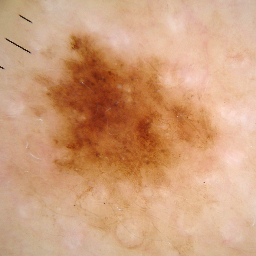

In [3]:
# Preview an image
array_to_img(train_images[0])

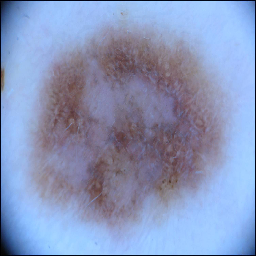

In [4]:
# Preview an image
array_to_img(test_images[0])

In [5]:
train_labels.shape

(2239, 9)

In [6]:
test_labels.shape

(118, 9)

In [7]:
test_images.shape

(118, 256, 256, 3)

In [8]:
train_images.shape

(2239, 256, 256, 3)

In [9]:
train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [10]:
dataframe=pd.DataFrame(train_labels, columns=['actinic_keratosis', 'basal_cell_carcinoma',\
            'dermatofibroma', 'melanoma', 'nevus', 'pigmented_benign_keratosis',\
            'seborrheic_keratosis', 'squamous_cell_carcinoma', 'vascular_lesion'])

In [11]:
dataframe

,actinic_keratosis,basal_cell_carcinoma,dermatofibroma,melanoma,nevus,pigmented_benign_keratosis,seborrheic_keratosis,squamous_cell_carcinoma,vascular_lesion
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
2234,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2235,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2236,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2237,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [12]:
sums=dataframe.sum(axis=0)

In [13]:
sums=pd.DataFrame(sums)

In [14]:
sums

,0
actinic_keratosis,114.0
basal_cell_carcinoma,376.0
dermatofibroma,95.0
melanoma,438.0
nevus,357.0
pigmented_benign_keratosis,462.0
seborrheic_keratosis,77.0
squamous_cell_carcinoma,181.0
vascular_lesion,139.0


In [15]:
sums['%'] = ((sums[0] / 2239*100).round(2).astype(str) + '%')

In [16]:
sums

,0,%
actinic_keratosis,114.0,5.09%
basal_cell_carcinoma,376.0,16.79%
dermatofibroma,95.0,4.24%
melanoma,438.0,19.56%
nevus,357.0,15.94%
pigmented_benign_keratosis,462.0,20.63%
seborrheic_keratosis,77.0,3.44%
squamous_cell_carcinoma,181.0,8.08%
vascular_lesion,139.0,6.21%


In [17]:
train_generator.class_indices 

{'actinic keratosis': 0,
 'basal cell carcinoma': 1,
 'dermatofibroma': 2,
 'melanoma': 3,
 'nevus': 4,
 'pigmented benign keratosis': 5,
 'seborrheic keratosis': 6,
 'squamous cell carcinoma': 7,
 'vascular lesion': 8}

In [18]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
print(train_img.shape)
print(test_img.shape)

(2239, 196608)
(118, 196608)


In [19]:
train_y = np.reshape(train_labels[:,0], (2239,1))
test_y = np.reshape(test_labels[:,0], (118,1))

In [20]:
X=train_img
y=train_y

In [21]:
model1 = Sequential()

In [22]:
model1.add(layers.Flatten())
model1.add(Dense(24, activation='relu', input_shape=(196608,)))
model1.add(Dense(12, activation='relu'))
model1.add(Dense(9, activation='softmax'))

In [23]:
model1.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
#model1.fit(X, y, epochs=50, batch_size=10)

The model did very well almost right away, 95% accuracy already at the fourth epoch.
Let us explore a bit more loss and accuracy using also a validation split.

In [25]:
results1 = model1.fit(X, y, epochs=50, batch_size=10, validation_split=0.2)

Epoch 1/50
180/180 [==============================] - 11s 55ms/step - loss: 2123.5581 - accuracy: 0.8448 - val_loss: 948.8156 - val_accuracy: 0.9487
Epoch 2/50
180/180 [==============================] - 9s 47ms/step - loss: 577.3361 - accuracy: 0.8794 - val_loss: 48.5094 - val_accuracy: 0.9487
Epoch 3/50
180/180 [==============================] - 8s 47ms/step - loss: 266.8559 - accuracy: 0.8850 - val_loss: 847.3026 - val_accuracy: 0.9487
Epoch 4/50
180/180 [==============================] - 8s 47ms/step - loss: 420.4381 - accuracy: 0.8900 - val_loss: 7.8945 - val_accuracy: 0.8214
Epoch 5/50
180/180 [==============================] - 9s 48ms/step - loss: 2.5876 - accuracy: 0.7203 - val_loss: 1.6147 - val_accuracy: 0.9487
Epoch 6/50
180/180 [==============================] - 8s 47ms/step - loss: 1.2288 - accuracy: 0.9492 - val_loss: 0.8260 - val_accuracy: 0.9487
Epoch 7/50
180/180 [==============================] - 9s 48ms/step - loss: 0.5327 - accuracy: 0.9492 - val_loss: 0.3204 - val_a

In [26]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

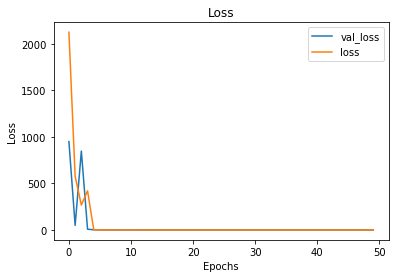

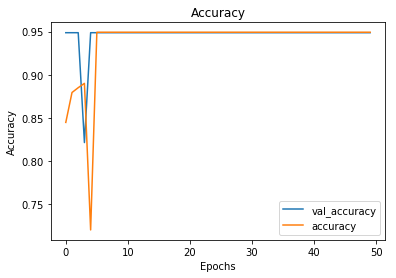

In [27]:
visualize_training_results(results1)

I just want to see out of curiosity what is the performance, with the same exact parameters, if I were to import the images in a smaller size.

In [28]:
# Directory path
train_data_dir = 'dataskin/Train'
test_data_dir = 'dataskin/Test'
#val_data_dir = 'dataset/validation_set'

# Get all the data in the directory data/validation (132 images), and reshape them
test_generator64 = ImageDataGenerator().flow_from_directory(
        test_data_dir, target_size=(64, 64), batch_size=118)

# Get all the data in the directory data/train (790 images), and reshape them
train_generator64 = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(64, 64), batch_size=2239)


# Create the datasets
train_images64, train_labels64 = next(train_generator64)
test_images64, test_labels64 = next(test_generator64)

Found 118 images belonging to 9 classes.
Found 2239 images belonging to 9 classes.


In [29]:
train_img64 = train_images64.reshape(train_images64.shape[0], -1)
test_img64 = test_images64.reshape(test_images64.shape[0], -1)
print(train_img.shape)
print(test_img.shape)

(2239, 196608)
(118, 196608)


In [32]:
train_y64 = np.reshape(train_labels64[:,0], (2239,1))
test_y64 = np.reshape(test_labels64[:,0], (118,1))

In [33]:
X64=train_img64
y64=train_y64

In [34]:
model2 = Sequential()

In [35]:
model2.add(Dense(24, activation='relu', input_shape=(12288,)))
model2.add(Dense(12, activation='relu'))
model2.add(Dense(9, activation='softmax'))

In [36]:
model2.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [37]:
#model2.fit(X64, y64, epochs=50, batch_size=10)

In [41]:
results2 = model2.fit(X64, y64, epochs=100, batch_size=10, validation_split=0.2)

Epoch 1/100
180/180 [==============================] - 1s 5ms/step - loss: 0.2171 - accuracy: 0.9531 - val_loss: 0.2803 - val_accuracy: 0.9330
Epoch 2/100
180/180 [==============================] - 1s 5ms/step - loss: 0.9716 - accuracy: 0.9458 - val_loss: 0.2508 - val_accuracy: 0.9330
Epoch 3/100
180/180 [==============================] - 1s 6ms/step - loss: 0.2212 - accuracy: 0.9525 - val_loss: 0.3631 - val_accuracy: 0.9330
Epoch 4/100
180/180 [==============================] - 1s 5ms/step - loss: 1.3086 - accuracy: 0.9475 - val_loss: 0.2508 - val_accuracy: 0.9330
Epoch 5/100
180/180 [==============================] - 1s 5ms/step - loss: 4.3906 - accuracy: 0.9475 - val_loss: 1.0809 - val_accuracy: 0.9308
Epoch 6/100
180/180 [==============================] - 1s 5ms/step - loss: 0.2342 - accuracy: 0.9520 - val_loss: 0.2593 - val_accuracy: 0.9330
Epoch 7/100
180/180 [==============================] - 1s 5ms/step - loss: 0.1999 - accuracy: 0.9531 - val_loss: 0.3283 - val_accuracy: 0.9330

Epoch 58/100
180/180 [==============================] - 1s 7ms/step - loss: 0.3517 - accuracy: 0.9525 - val_loss: 0.4263 - val_accuracy: 0.9330
Epoch 59/100
180/180 [==============================] - 1s 6ms/step - loss: 0.5946 - accuracy: 0.9447 - val_loss: 0.2303 - val_accuracy: 0.9330
Epoch 60/100
180/180 [==============================] - 1s 7ms/step - loss: 0.2195 - accuracy: 0.9531 - val_loss: 0.2307 - val_accuracy: 0.9330
Epoch 61/100
180/180 [==============================] - 1s 4ms/step - loss: 2.4779 - accuracy: 0.9458 - val_loss: 0.2502 - val_accuracy: 0.9330
Epoch 62/100
180/180 [==============================] - 1s 5ms/step - loss: 0.7423 - accuracy: 0.9525 - val_loss: 0.2752 - val_accuracy: 0.9330
Epoch 63/100
180/180 [==============================] - 1s 5ms/step - loss: 0.2859 - accuracy: 0.9520 - val_loss: 1.9912 - val_accuracy: 0.9308
Epoch 64/100
180/180 [==============================] - 1s 8ms/step - loss: 0.3253 - accuracy: 0.9520 - val_loss: 0.2554 - val_accuracy:

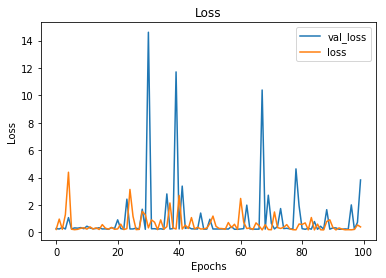

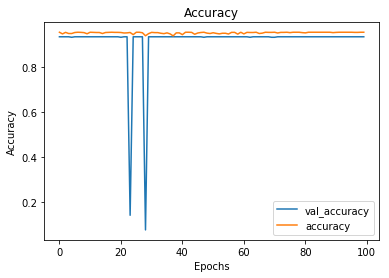

In [42]:
visualize_training_results(results2)

In [43]:
history2 = results2.history
history2

{'loss': [0.21707221865653992,
  0.971622109413147,
  0.22121582925319672,
  1.3085891008377075,
  4.390577793121338,
  0.2341804802417755,
  0.19993025064468384,
  0.2249990701675415,
  0.3044610023498535,
  0.3400987684726715,
  0.23821032047271729,
  0.4064410328865051,
  0.24885228276252747,
  0.3325413763523102,
  0.21519121527671814,
  0.5706964731216431,
  0.31132271885871887,
  0.23489271104335785,
  0.3634378910064697,
  0.22957052290439606,
  0.2532457411289215,
  0.6060331463813782,
  0.20930370688438416,
  0.27351418137550354,
  3.135255813598633,
  1.1687936782836914,
  0.2054610550403595,
  0.22190973162651062,
  1.5299264192581177,
  1.2901465892791748,
  0.3337964415550232,
  0.9151530861854553,
  0.7465850114822388,
  0.2028733342885971,
  0.9141597747802734,
  0.23198765516281128,
  0.42089059948921204,
  2.1485893726348877,
  0.3302038609981537,
  0.24621954560279846,
  2.6960103511810303,
  0.2456289529800415,
  0.5291640758514404,
  0.28816577792167664,
  1.0825701

Look at lab on https://github.com/learn-co-curriculum/dsc-image-classification-with-mlps-lab/tree/solution
might need to do some one hot encoding.
Also, just like it shows there, as a naive model maybe decrease the number of layers and keep epochs at like 5.
If results are the same, try to understand why the loss still showes such high peaks.And why the accuracy drops like that.
Might also be worth doing CNN from the start with 2D layers instead of this basic NN.